We are a group of data scientist and marketing specialist for a bank. While we are not able to access data related to real-time campaign effectiveness due to privacy issue, the strategy I have built is generally based on the data we assumed we should be able to access.

### Part I: what data we have

1. demographic data: this is data related to demographic feature of customers. This is what we are able to access and retract from the Internet. In this question, we referred to columns from the file `UserChurn`. 
2. real-time campaign data: current banks usually provide digital service for customers. Take DBS as an example, it has two digital app for customers. Therefore, we assume that banks would be able to retract customers' real-time data based on their interaction with app

### Part II: what features we need

Despite the demographic features provided in the main dataset `UserChurn`, we generally required real-time data like transaction data and digital service data. Transaction data is available in this project as `bank_transaction`.
1. `transaction_amount `
2. `transaction_time`
3. `transaction_account`: this is a feature not appeared in the dataset `bank_transaction`,but usually available for real-bank, which is the account that interacted with this transction. Even though we may not be able to have the full information with such account, but we would be able to classify the `transaction_type` into `individual` or `business` based on the type of `transaction_account`
4. `account_balance`
5. `transaction_location`

For digital service data, their would usually be a lot of fetaures, however, we will classify them into some large category:
1. `stay_time`: how long does the customer stay for the page of some financial product
2. `location`: app would be able to retract user's real-time location based on their phone. For example, when you arrived in Malaysia, your phone operator would send a notification such as "welcome to Malaysia." Such information is usually easily accessed by the app

### Part III: How do we build a personalized campaign strategy

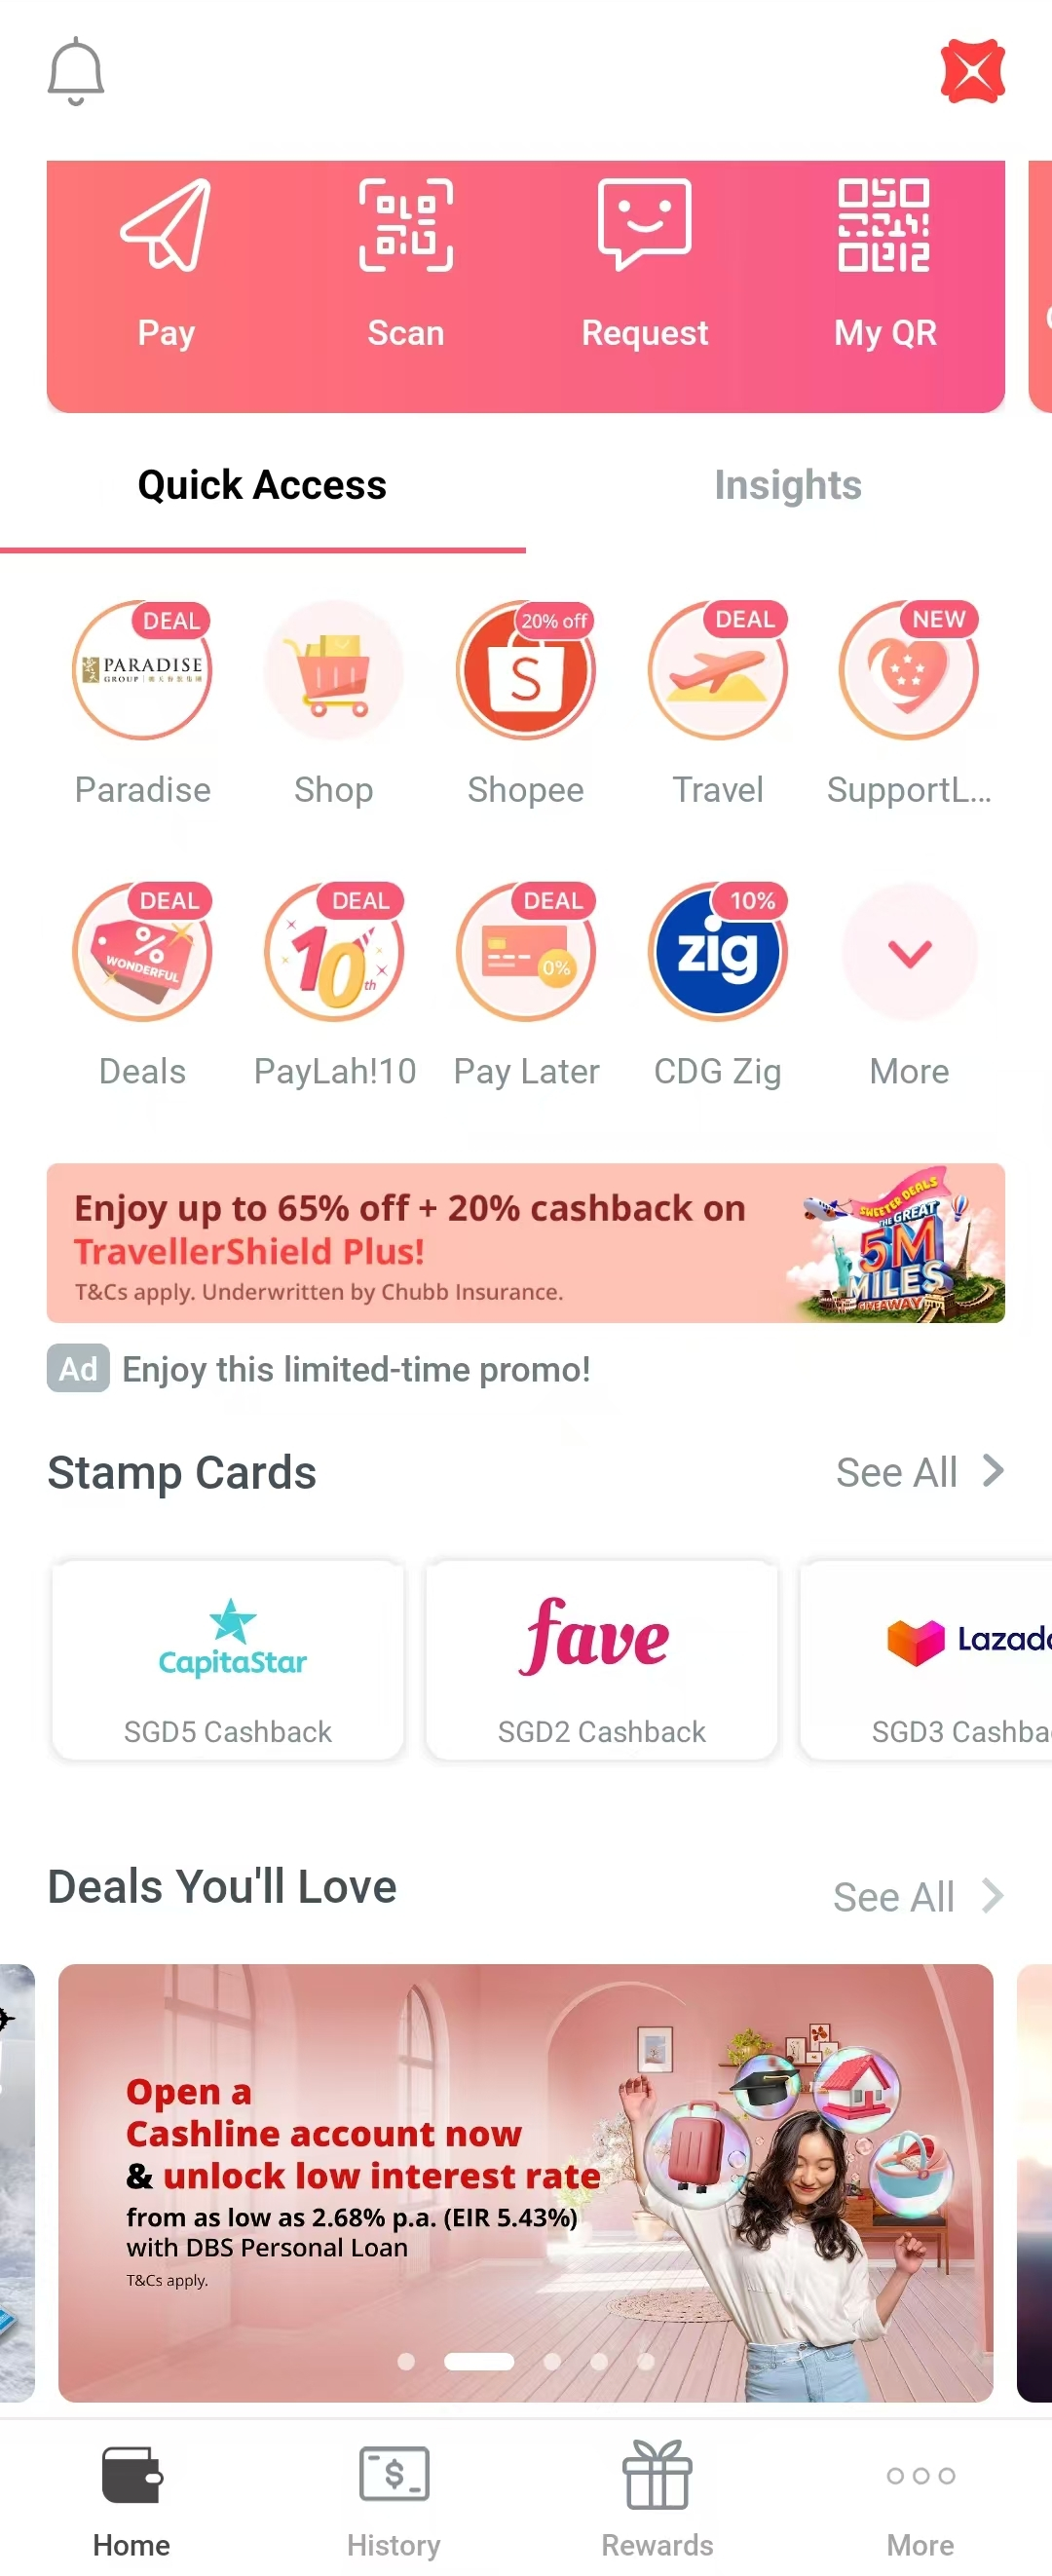

In [ ]:
from IPython.display import Image
Image(filename='../picture/paylah_screenshot.jpg', width=300, height=200)

Take DBS paylah as an example, this is how its payment page look like, which can help to inspire us what kind of campaign we can offer

Before proceeding, we need to clarify the purpose of the campaign. The campaign aims to make customers more active, encourage them to purchase banking products, and increase their transaction volume with their accounts at the bank. The banking products include: savings accounts, credit cards, loans (categorized as personal loans, including home and car loans; commercial loans, mainly for businesses), investment products (such as funds and fixed deposits), and insurance.

So, what types of campaigns can we consider? The first category focuses on increasing customer activity. We could take inspiration from DBS:
1. Collaborate with other businesses. For instance, offer discounts or reward points if customers use DBS to pay on Shopee, thereby incentivizing spending.
2. Directly stimulate spending. For example, offer a 100 cashback if monthly spending reaches 1500.

The second category focuses on promoting the purchase of banking products:
- **Savings Accounts**: Usually the first product customers open with the bank, so the main goal is to keep customers active. We can rely on activity-based campaigns (the first type) to retain savings account customers.
- **Credit Cards and Personal Loans**: These can be tailored based on customer spending behaviors. Different spending levels may be associated with different credit card limits, while loans can be offered through two main methods:
  1. Trigger Mechanism: If a customer browses loan-related products in the bank app, automatically push relevant loan services.
  2. Recent Transactions: If there are multiple large transactions, this could signal a need for substantial funds, and we can offer a commercial loan.
  3. For personal loans, use the customer’s location (captured by the bank app). For instance, if a customer has visited car or real estate businesses but hasn’t completed a transaction, offer a time-limited, low-interest loan.

- **Insurance**: Divided into commercial insurance and personal insurance. For customers who have recently visited medical facilities, recommend suitable personal insurance; bundle commercial insurance with commercial loans.

- **Investment Products**: Recommend these based on the customer’s account balance. If the balance reaches a certain threshold, recommend suitable investment products. If a customer stays on a specific investment product page in the app for over 30 seconds, push a limited-time offer for that product.

This layered campaign strategy can help target customer needs more precisely.

### Part IV: Campaign Strategy

1. Increasing Customer Activity:
- **Cashback Promotion**: for customer of different banking behavior assign different cashback promotion:
`High Banking Behavior`: 4000, `Moderate Banking Behavior`:3000, `Low Banking Behavior`: 1500
- In this campaign, we temporarily do not consider business collaboration. This is because it's hard to determine what kind of business we want to collaborate for a virtual bank.
2. Promoting Banking Products:
- **Credit Card**: High, moderate, low banking behavior will be recommended with different level of card. If they have high banking activity with their credit card, send a SMS: "Increase your limit by spending up to XXX！" XXX is an amount increased by 10%, 20%, 30% of the original limit, to be optimized later.
- **Loan**: if a customer's location has been to car/real-estate business recently, recommend them loan based on their credit score; the difference is to be optimized later
- **Business Loan** if stay for some time for business loan, recommend them based on their banking behavior and credit scores
- **Insurance**:For customers who have recently visited medical facilities, recommend suitable personal insurance; bundle commercial insurance with commercial loans.
- **Investment Products**: different products of different interest is recommended based on their account balance when they showed their interest (stay for the page of the specific product)


### Part V: optimizing campaign effectiveness using real-time metrics

According to the Campaign Strategies above, we want to optimize some choice of the barriers for different promotions. The metrics we would like to use conversion rate and click-through rate

**real-time metric**: 
- campaign `outcome`: this can be used to generate `conversion rate` based on number of successful `outcome`/number of campaign
- `click-through rate`: scratch from the app, number of `click` per campaign

In [2]:
import numpy as np

# 定义触发事件类，包含成功、失败和未知状态
class TriggerEvent:
    def __init__(self, name, initial_threshold):
        self.name = name  # 触发事件名称
        self.successes = 0  # 成功次数
        self.failures = 0  # 失败次数
        self.unknowns = 0  # 未知次数
        self.threshold = initial_threshold  # 初始阈值（如停留时间、交易次数）

    # 使用贝塔分布采样模拟不同阈值的效果
    def sample(self):
        return np.random.beta(self.successes + 1, self.failures + 1) * self.threshold

    # 更新阈值，根据反馈动态调整
    def update(self, outcome):
        if outcome == "success":
            self.successes += 1
        elif outcome == "failure":
            self.failures += 1
        elif outcome == "unknown":
            self.unknowns += 1  # 未知状态，不更新阈值
        self.adjust_threshold()  # 动态调整阈值

    # 动态调整阈值
    def adjust_threshold(self):
        adjustment = 0.1 * self.threshold
        if self.successes > self.failures:
            self.threshold += adjustment
        else:
            self.threshold = max(self.threshold - adjustment, 1)  # 保证阈值不低于1

# 初始化触发事件
trigger_events = {
    "credit_limit_increase": TriggerEvent("Credit Limit Increase", initial_threshold=500),
    "loan_recommendation": TriggerEvent("Loan Recommendation", initial_threshold=15),
    "business_loan": TriggerEvent("Business Loan", initial_threshold=5),
    "insurance_recommendation": TriggerEvent("Insurance Recommendation", initial_threshold=30),
    "investment_product": TriggerEvent("Investment Product", initial_threshold=100000)
}

# 模拟优化过程
def optimize_trigger_conditions(events, transaction_data, digital_app_data, campaign_outcomes, num_rounds=1000):
    for round in range(num_rounds):
        for event_name, event in events.items():
            # 基于当前事件的触发条件进行采样
            sampled_threshold = event.sample()

            # 模拟活动结果，替换为实际反馈数据
            outcome = np.random.choice(["success", "failure", "unknown"], p=[0.3, 0.5, 0.2])

            # 更新模型，根据活动结果（包括未知状态）调整触发条件
            event.update(outcome)

    # 输出最终优化后的触发条件
    for event_name, event in events.items():
        print(f"Event '{event_name}' - Successes: {event.successes}, Failures: {event.failures}, Unknowns: {event.unknowns}, Optimized Threshold: {event.threshold}")

# 模拟交易数据、应用数据和活动反馈
transaction_data = {"recent_transactions": [500, 1500, 3000]}  # 模拟交易数据
digital_app_data = {"pages_visited": ["loan", "credit card", "investment"]}  # 模拟应用数据
campaign_outcomes = ["success", "failure", "unknown"]  # 活动反馈

# 运行优化过程
optimize_trigger_conditions(trigger_events, transaction_data, digital_app_data, campaign_outcomes)


Event 'credit_limit_increase' - Successes: 301, Failures: 496, Unknowns: 203, Optimized Threshold: 1
Event 'loan_recommendation' - Successes: 309, Failures: 495, Unknowns: 196, Optimized Threshold: 1
Event 'business_loan' - Successes: 314, Failures: 495, Unknowns: 191, Optimized Threshold: 1
Event 'insurance_recommendation' - Successes: 281, Failures: 512, Unknowns: 207, Optimized Threshold: 1
Event 'investment_product' - Successes: 313, Failures: 484, Unknowns: 203, Optimized Threshold: 1
